## Source

Analysis and Scenario Development in Uganda’s Transport Sector  
- Road: Table 4-4, page 44.  
- Rail: Table 5-1, page 47.  
- Water: Table 6-2, page 52.  
- Aviation: Table 7-1, page 55.



In [16]:
import numpy as np
import pandas as pd
import os
from utils.utils import EDAUtils, TransportUtils, GeneralUtils

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
edau = EDAUtils()
tu = TransportUtils()
gu = GeneralUtils()

In [19]:
# Set up paths
CURRENT_DIR_PATH = os.getcwd()
OUTPUT_DATA_DIR_PATH = os.path.join(CURRENT_DIR_PATH, "output_data")
INPUT_DATA_DIR_PATH = os.path.join(CURRENT_DIR_PATH, "input_data")

In [20]:
# Load gdp data
trde_freight_df = pd.read_csv(os.path.join(OUTPUT_DATA_DIR_PATH, "gdp_mmm_usd.csv"))
# Filter to 2015 and onwards
trde_freight_df = trde_freight_df[trde_freight_df['year'] >= 2015].reset_index(drop=True)


trde_freight_df.head()

,year,gdp_mmm_usd
0,2015,79.03
1,2016,82.81
2,2017,85.41
3,2018,90.79
4,2019,96.64


In [21]:
trde_freight_df.tail()

,year,gdp_mmm_usd
31,2046,687.103988
32,2047,740.904231
33,2048,798.917032
34,2049,861.472235
35,2050,928.925512


In [22]:
# raw inputs
road_freight_trde = 45.1e9 / 1_000_000 # mtkm 2019 data
rail_freight_trde = {
    2015: 166.17e6 / 1_000_000,  # mtkm
    2016: 125.6e6 / 1_000_000,
    2017: 70.05e6 / 1_000_000,
    2018: -87.28e6 / 1_000_000,
    2019: 77.54e6 / 1_000_000,
    2020: 98.7e6 / 1_000_000,
}

inland_water_freight_trde = 6571e6 / 1_000_000  # mtkm 2019 data


# raw inputs
international_cargo_exports = {
    2015: 32660,
    2016: 39376,
    2017: 47712,
    2018: 41667,
    2019: 41667 # NOTE: 2019 data is not available, using 2018 value
} # in tonnes

# NOTE: We assume that the domestic cargo is the same from 2013 to 2019 
# as the data is not available for these years.
domestic_cargo = {
    2009: 8.0,
    2010: 0.580, 
    2012: 0.950,
    2013: 1.265, 
    2014: 1.265, 
    2015: 1.265, 
    2016: 1.265, 
    2017: 1.265, 
    2018: 1.265, 
    2019: 1.265 
} # in tonnes


aviation_freight_trde = tu.compute_freight_mtkm(domestic_cargo, international_cargo_exports)
aviation_freight_trde


{2009: 0.0024,
 2010: 0.000174,
 2012: 0.000285,
 2013: 0.00037949999999999995,
 2014: 0.00037949999999999995,
 2015: 81.6503795,
 2016: 98.44037949999999,
 2017: 119.2803795,
 2018: 104.1678795,
 2019: 104.1678795}

In [23]:
base_year = 2019

base_road_freight_mtkm = road_freight_trde
base_rail_freight_mtkm = rail_freight_trde.get(base_year, 0)
base_inland_water_freight_mtkm = inland_water_freight_trde
base_aviation_freight_mtkm = aviation_freight_trde.get(base_year, 0)

base_freight_mtkm = (
    base_road_freight_mtkm
    + base_rail_freight_mtkm
    + base_inland_water_freight_mtkm
    + base_aviation_freight_mtkm
)

# Set GDP scaling factor
gdp_scaling = trde_freight_df.loc[trde_freight_df['year'] == base_year, 'gdp_mmm_usd'].values[0]

In [26]:
# Filter the trde_freight_df to only include <= base_year
trde_freight_df = trde_freight_df[trde_freight_df['year'] <= base_year].reset_index(drop=True)
trde_freight_df

,year,gdp_mmm_usd
0,2015,79.03
1,2016,82.81
2,2017,85.41
3,2018,90.79
4,2019,96.64


In [27]:
# Scale by gdp
trde_freight_df['deminit_trde_freight_mt_km'] = (
    (base_freight_mtkm)
    * (trde_freight_df['gdp_mmm_usd'] / gdp_scaling)
)

In [28]:
trde_freight_df.head()

,year,gdp_mmm_usd,deminit_trde_freight_mt_km
0,2015,79.03,42403.968375
1,2016,82.81,44432.147553
2,2017,85.41,45827.191432
3,2018,90.79,48713.859151
4,2019,96.64,51852.707879


<Axes: >

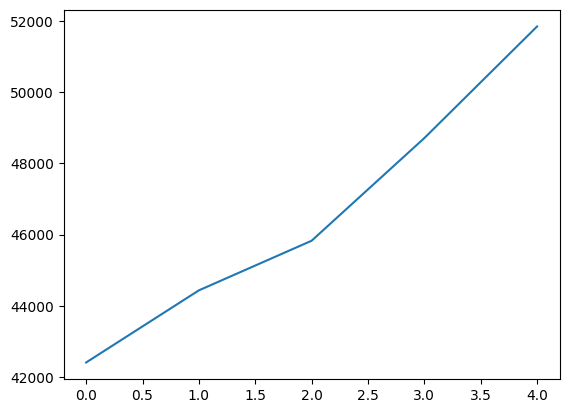

In [29]:
trde_freight_df.deminit_trde_freight_mt_km.plot()

In [30]:
# Drop gdp column as it is no longer needed
trde_freight_df.drop(columns=['gdp_mmm_usd'], inplace=True)
trde_freight_df.head()

,year,deminit_trde_freight_mt_km
0,2015,42403.968375
1,2016,44432.147553
2,2017,45827.191432
3,2018,48713.859151
4,2019,51852.707879


In [31]:
# project to 2100
trde_freight_df_extended = gu.extend_projection(trde_freight_df, base_year, 2100)
trde_freight_df_extended


,year,deminit_trde_freight_mt_km
0,2015,42403.968375
1,2016,44432.147553
2,2017,45827.191432
3,2018,48713.859151
4,2019,51852.707879
...,...,...
82,2096,51852.707879
83,2097,51852.707879
84,2098,51852.707879
85,2099,51852.707879


## Validation

In [32]:
og_df = pd.read_csv(os.path.join(INPUT_DATA_DIR_PATH, "sisepuede_raw_global_inputs_uganda.csv"))
og_df = og_df[["deminit_trde_freight_mt_km"]]
og_df.head()

,deminit_trde_freight_mt_km
0,77043.00876
1,76763.27285
2,76374.47397
3,75903.71869
4,75388.09546


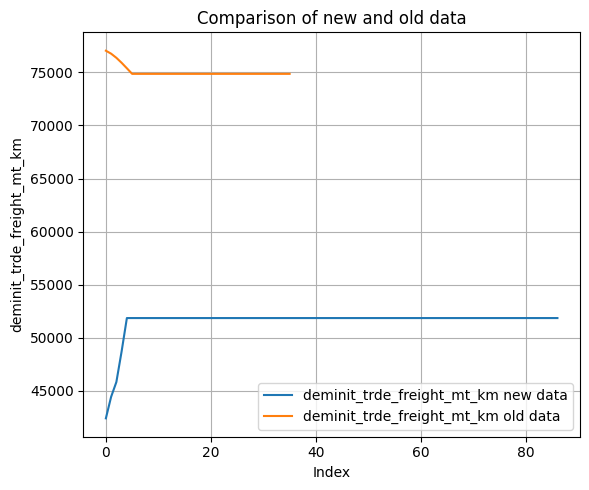

In [33]:
edau.compare_variables(trde_freight_df_extended,
                       og_df,
                       ["deminit_trde_freight_mt_km"]
                        )

In [34]:
trde_freight_df_extended.to_csv(os.path.join(OUTPUT_DATA_DIR_PATH, "deminit_trde_freight_mt_km.csv"), index=False)